# Loss Given Default (LGD) and Recovery Rate

Here, we compute the **Loss Given Default (LGD)**, which represents the proportion of the loan not recovered after default and accounts for any recoveries or collateral.

The dependent variable is the **recovery rate**, defined as:

$$
\text{Recovery Rate} = \frac{\text{Recoveries} }{\text{Funded Amount}}
$$

This measures the fraction of the loan lost after recovery efforts.  

We will model the recovery rate using **tweedie regression**, which is appropriate for continuous values constrained between 0 and 1.

Unlike PD model, here we will work with customer that were charged off and not the whole dataset.

In [20]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.othermod.betareg import BetaModel

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import pickle

import warnings
warnings.filterwarnings("ignore")

In [21]:
df_prep = pd.read_csv('data/loan_inputs_train.csv')
df_prep.head()

,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,mths_since_last_delinq:70_80,mths_since_last_record:<36,mths_since_last_record:37_66,mths_since_last_record:67_121,mths_since_last_record:122_127,dti_factor,dti:<1,dti:1_6,dti:7_30,dti:30_40
0,269056,269056,NaN,NaN,20000,20000,20000.0,36 months,7.46,621.76,...,0,0,0,1,0,"(-0.999, 19.98]",1,0,0,0
1,499174,499174,NaN,NaN,30000,30000,30000.0,36 months,11.49,989.14,...,0,0,0,0,0,"(19.98, 39.96]",0,0,1,0
2,85143,85143,NaN,NaN,17000,17000,17000.0,60 months,6.67,333.98,...,0,0,0,0,0,"(19.98, 39.96]",0,0,1,0
3,260335,260335,NaN,NaN,24000,24000,24000.0,36 months,6.83,739.19,...,0,0,0,1,0,"(-0.999, 19.98]",0,0,1,0
4,338124,338124,NaN,NaN,30000,30000,30000.0,60 months,9.92,636.24,...,0,0,0,0,0,"(-0.999, 19.98]",0,0,1,0


In [22]:
df_defaults = df_prep[df_prep['loan_status'].isin(['Charged Off'])]

df_defaults['mths_since_last_delinq'].fillna(0) #missing values
df_defaults['mths_since_last_record'].fillna(0)

104         0.0
132         0.0
246         0.0
415       111.0
489         0.0
          ...  
399018      0.0
399061     96.0
399548      0.0
399750      0.0
399912     27.0
Name: mths_since_last_record, Length: 6047, dtype: float64

### Dependent variable: recovery rate

In [23]:
df_defaults['recovery_rate'] = df_defaults['recoveries'] / df_defaults['funded_amnt']
df_defaults['recovery_rate'].describe()

count    6047.000000
mean        0.024317
std         0.068680
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.104069
Name: recovery_rate, dtype: float64

`recovery_rate` is not bounded within 0 and 1, which happen due to many reasons. So we clip it within the bounds

In [24]:
eps = 1e-4
df_defaults['recovery_rate'] = np.clip(df_defaults['recovery_rate'], eps, 1-eps)
df_defaults['recovery_rate'].describe()

count    6047.000000
mean        0.024330
std         0.067635
min         0.000100
25%         0.000100
50%         0.000100
75%         0.000100
max         0.999900
Name: recovery_rate, dtype: float64

### Explore dependent variables

(array([5.053e+03, 1.700e+01, 1.400e+01, 3.700e+01, 7.100e+01, 9.300e+01,
        5.200e+02, 1.310e+02, 1.000e+00, 1.900e+01, 3.400e+01, 7.000e+00,
        2.000e+00, 3.000e+00, 4.000e+00, 3.000e+00, 2.000e+00, 4.000e+00,
        4.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 3.000e+00, 3.000e+00,
        3.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 7.000e+00]),
 array([1.00000e-04, 2.00960e-02, 4.00920e-02, 6.00880e-02, 8.00840e-02,
        1.00080e-01, 1.20076e-01, 1.40072e-01, 1.60068e-01, 1.80064e-01,
        2.00060e-01, 2.20056e-01, 2.40052e-01, 2.60048e-01, 2.80044e-01,
        3.00040e-01, 3.20036e-01, 3.40032e-01, 3.60028e-01, 3.80024e-01,
        4.00020e-01, 4.20016e-01, 4.40012e-01, 4.60008e-01, 4.80004e-01,
        5.0

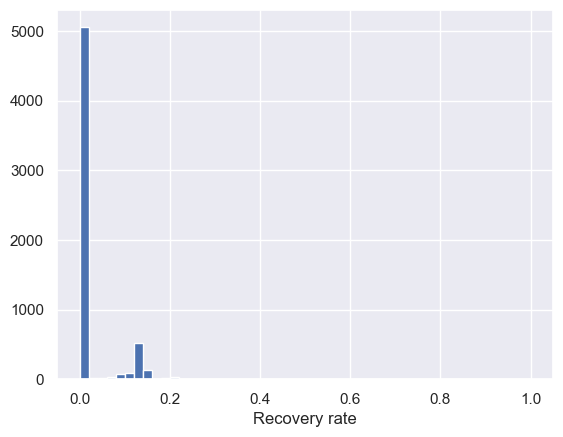

In [25]:
plt.xlabel('Recovery rate')
plt.hist(df_defaults['recovery_rate'], bins=50)

### Train

In [26]:
#remove dependent variables from inputs and pass with target variable
x_train, x_test, y_train, y_test = train_test_split(df_defaults.drop(['recovery_rate', 'loan_status'], axis=1),
                                                    df_defaults['recovery_rate'],
                                                    test_size=0.2,
                                                    random_state=42)

In [27]:
with open('data/dummy_variables_revised.txt') as f:
    all_cols_revised = [line.strip() for line in f] #all columns

with open('data/ref_variables_revised.txt') as f:
    ref_cols_revised = [line.strip() for line in f] #reference columns (safest baseline variables)

inputs_train_w_ref_cols = x_train.loc[:, all_cols_revised]
inputs_train = inputs_train_w_ref_cols.drop(ref_cols_revised, axis=1)
inputs_train.head()

,grade:B,grade:C,grade:D,grade:E,grade:F_G,addr_state:HI_MS_OK_AL,addr_state:NY_FL,addr_state:NM_SD_NV,addr_state:MD_MI_NC,addr_state:AR,...,mths_since_last_delinq:3_16,mths_since_last_delinq:48_64,mths_since_last_delinq:65_70,mths_since_last_delinq:70_80,mths_since_last_record:<36,mths_since_last_record:37_66,mths_since_last_record:122_127,dti:<1,dti:1_6,dti:30_40
375967,False,True,False,False,False,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
264863,False,True,False,False,False,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
73007,False,True,False,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
75064,True,False,False,False,False,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
342702,False,True,False,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [28]:
inputs_train_num = inputs_train.apply(pd.to_numeric)
y_train = pd.to_numeric(y_train)

x = sm.add_constant(inputs_train_num.astype(float))
y = y_train.astype(float)

family = sm.families.Tweedie(link=sm.families.links.Log(), 
                             var_power=0.5)

logit = sm.GLM(y, x, family=family)
lgd_model = logit.fit()

print(lgd_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          recovery_rate   No. Observations:                 4837
Model:                            GLM   Df Residuals:                     4788
Model Family:                 Tweedie   Df Model:                           48
Link Function:                    Log   Scale:                        0.028129
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Fri, 13 Feb 2026   Deviance:                       83.175
Time:                        02:27:56   Pearson chi2:                     135.
No. Iterations:                    24   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

### Test

In [29]:
with open('data/dummy_variables_revised.txt') as f:
    all_cols_revised = [line.strip() for line in f] #all columns

with open('data/ref_variables_revised.txt') as f:
    ref_cols_revised = [line.strip() for line in f] #reference columns (safest baseline variables)

inputs_test_w_ref_cols = x_test.loc[:, all_cols_revised]
inputs_test = inputs_test_w_ref_cols.drop(ref_cols_revised, axis=1)
inputs_test.head()

,grade:B,grade:C,grade:D,grade:E,grade:F_G,addr_state:HI_MS_OK_AL,addr_state:NY_FL,addr_state:NM_SD_NV,addr_state:MD_MI_NC,addr_state:AR,...,mths_since_last_delinq:3_16,mths_since_last_delinq:48_64,mths_since_last_delinq:65_70,mths_since_last_delinq:70_80,mths_since_last_record:<36,mths_since_last_record:37_66,mths_since_last_record:122_127,dti:<1,dti:1_6,dti:30_40
353542,False,False,True,False,False,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
153469,False,True,False,False,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
386168,False,False,True,False,False,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
286449,False,False,True,False,False,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
88253,False,False,False,True,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
inputs_test_num = inputs_test.apply(pd.to_numeric)
loan_target_test_num = pd.to_numeric(y_test)

tr = 0.5
X_test_const = sm.add_constant(inputs_test.astype(float))
y_pred_prob = lgd_model.predict(X_test_const)  # probabilities of Y=1
y_pred_class = (y_pred_prob >= tr).astype(int) 

y_pred = y_pred_prob
y_true = loan_target_test_num.astype(float)

# RMSE manually
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# R^2
r2 = r2_score(y_true, y_pred)

# MAE
mae = mean_absolute_error(y_true, y_pred)

print("RMSE:", rmse)
print("R^2:", r2)
print("MAE:", mae)

RMSE: 0.06584301710982116
R^2: 0.008386628068026702
MAE: 0.03922423042475649


- The $R^2$ is low, but that is expected given zero-inflated data sets. 

- A better approach would be to use two part approach: binrary classification for 0 or not 0 and beta regression for (0,1)

In [31]:
y_pred.describe() #is within (0,1)

count    1210.000000
mean        0.024360
std         0.010585
min         0.006342
25%         0.017544
50%         0.022036
75%         0.028812
max         0.151876
dtype: float64

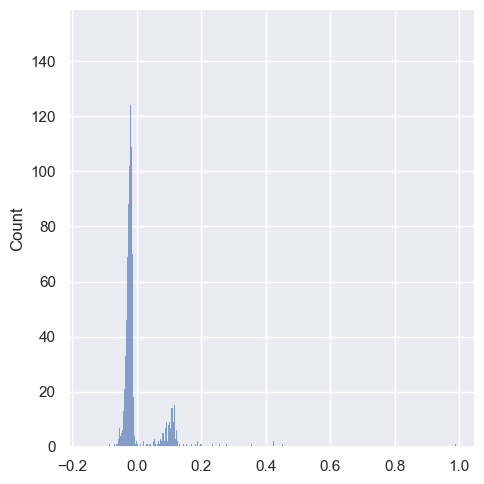

In [32]:
sns.displot(y_true-y_pred)

In [33]:
#save model
with open('data/lgd_model.pkl', 'wb') as f:
    pickle.dump(lgd_model, f)